- load model #16
- explainer = shap.KernelExplainer(model, X_train)
- get shap_values = explainer.shap_values(X_test_shap)
- save shap_values_16_n_samples.npy\
=> shap values for 212 features! 128 svd components + 84 handselected genes
- same steps for model #17

In [1]:
%%capture output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install tables
# necessary for pd.read_hdf()
!pip install shap

!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress
# !pip install catboost
!pip install shap
!pip install anndata

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import shap

import anndata as ad

In [3]:
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [4]:
import scanpy as sc
plt.rcParams['figure.dpi'] = 100
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

scanpy==1.9.5 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.2 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.8


## data load

In [5]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'
private_data_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

# multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
# multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
# multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
# multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite  (code from codebase, same steps as in run_model.ipynb)

In [6]:
# short names of models used in ensemble
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [7]:
# create model_name_list containing the actual file name of each model from mlp_model_name
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [8]:
# list of file names: test sets that correspond to each model in model_name_list
# weights used for weighting model predictions in ensemble
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()
weight_sum

# create dict of shape {model_name: [test set, weight]}
model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model (from codebase)

Only need to load the model, not run the predictions as they are in run_model.ipynb

In [9]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [10]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [11]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [12]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [13]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### model #16

In [14]:
# only need model, not whole prediction

# model #16: cite_mlp_corr_svd_128_flg_donor_val_30

model_name = 'cite_mlp_corr_svd_128_flg_donor_val_30'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model16 = CiteModel_mish(feature_dims)
else:
    model16 = CiteModel(feature_dims)
    
model16 = model16.to(device)
model16.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

<All keys matched successfully>

### model #17

In [15]:
# only need model, not whole prediction
# model #17: cite_mlp_corr_svd_64_flg_donor_val_38

model_name = 'cite_mlp_corr_svd_64_flg_donor_val_38'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model17 = CiteModel_mish(feature_dims)
else:
    model17 = CiteModel(feature_dims)
    
model17 = model17.to(device)
model17.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

<All keys matched successfully>

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [14]:
# X_train for model #16: 'X_svd_128.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_128.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

# explainer16 = shap.KernelExplainer(model16, shap.sample(X_train, 1000))

med = X_train.median().values.reshape((1,X_train.shape[1]))
# explainer16 = shap.KernelExplainer(model16, med)

# zeros = np.zeros((1,212), dtype=float)
explainer16 = shap.KernelExplainer(model16, med)

X_train:  (70988, 212)
X_test:  (48203, 148)


In [15]:
X_test_shap = ad.read_h5ad('X_test_shap_16_50_samples.h5ad')

In [16]:
np.set_printoptions(suppress=True)
med[:,:15].round(2)

array([[87.35, -2.75, -2.78, -0.3 , -0.38, -0.92, -0.12, -0.59,  0.13,
        -0.51,  0.2 ,  0.12, -0.13, -0.13,  0.06]], dtype=float32)

In [17]:
# features: genes and svd -> omnipath: genes
# model: mostly relying on genes or svd? -> later

In [18]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer16.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_16_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [19]:
# shap_values[0]

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [20]:
# X_train for model #17: 'X_svd_64.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_64.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer17 = shap.KernelExplainer(model17, med)  #shap.sample(X_train, 1000))

X_train:  (70988, 148)
X_test:  (48203, 148)


In [21]:
X_test_shap = ad.read_h5ad('X_test_shap_17_50_samples.h5ad')

In [22]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer17.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_17_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [23]:
# shap_values[0]

### same steps for private test data

steps for model 16: compute shap values on 50 samples per cell type

In [16]:
X_train_p_sampled = ad.read_h5ad('private_train_input_max_samples.h5ad')  # 160 samples per cell type -> even distr.
X_train_p_sampled.obs

,kaggle_dataset,day,donor,cell_type,ID
"TACAGGTAGCAGGGAG-1-('31800', 2)",train,2,31800,BP,46924
"TTTCGATGTACCTATG-1-('31800', 2)",train,2,31800,BP,47398
"AACGGGAGTTGACTAC-1-('31800', 2)",train,2,31800,BP,53848
"ACTTCCGTCTGGCCGA-1-('13176', 2)",train,2,13176,BP,24550
"GGAGGATCACTGCACG-1-('13176', 4)",train,4,13176,BP,39974
...,...,...,...,...,...
"CCTAACCGTTAAGTCC-1-('31800', 4)",train,4,31800,NeuP,68712
"TCCGGGAAGATTAGCA-1-('31800', 4)",train,4,31800,NeuP,69027
"CATGCCTTCGTAGGAG-1-('31800', 3)",train,3,31800,NeuP,56509
"AGGGCTCTCGACCTAA-1-('31800', 3)",train,3,31800,NeuP,55779


In [17]:
X_train_p_16 = pd.read_pickle('private_X_train_svd_128.pkl')            # use full train set
X_train_p_16 = X_train_p_16.iloc[np.sort(X_train_p_sampled.obs['ID'])]     # use 160 samples per cell type -> even distr.

X_test_p_16 = ad.read_h5ad('private_test_input_128_svd_50_samples.h5ad')

print('X_train: ', X_train_p_16.shape)
print('X_test: ', X_test_p_16.shape)

med = X_train_p_16.median().values.reshape((1,X_train_p_16.shape[1]))
explainer16_p = shap.KernelExplainer(model16, med.astype('float32'))

# shap_values_16_p = explainer16_p.shap_values(X_test_p_16.to_df(), nsamples=300)

X_train:  (1120, 212)
X_test:  (350, 212)


In [26]:
# np.save('shap_values_16_50_samples_p_ct_distr.npy', np.array(shap_values_16_p, dtype=object), allow_pickle=True)

### analyse SHAP properties on 5 samples per cell type

use data with svd components and handselected genes but only use handselected genes for comparison between models 16, 17, and ensemble.

In [18]:
X_test_p_16 = ad.read_h5ad('private_test_input_128_svd_5_samples.h5ad')
X_test_p_16.to_df().median().values.reshape((1,X_train_p_16.shape[1]))[:,-84:]  # X_test column median of the handselected genes

array([[0.       , 0.       , 0.       , 1.8138117, 0.       , 0.       ,
        0.       , 2.1552792, 1.7742511, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 1.2818234,
        1.5404364, 1.6152524, 2.0646195, 0.       , 0.       , 1.8752995,
        0.       , 1.5618597, 0.       , 0.       , 1.7934363, 0.       ,
        0.       , 1.5125499, 0.       , 1.977549 , 0.       , 1.8843051,
        0.       , 2.1789148, 0.       , 1.9506857, 2.0815597, 1.9396279,
        1.8983781, 1.9506857, 1.7197546, 1.7368575, 0.       , 1.6112658,
        1.5892453, 1.3797706, 0.       , 0.       , 0.       , 0.       ,
        0.       , 2.3780053, 0.       , 1.7049805, 0.       , 0.       ,
        1.952436 , 0.       , 2.251359 , 2.2146637, 2.2094057, 2.22894  ,
        2.0633488, 2.034886 , 0.       , 1.5620666, 0.       , 0.       ,
        1.430469 , 0.       , 1.810973

In [28]:
# shap_values_16_p_5 = explainer16_p.shap_values(X_test_p_16.to_df(), nsamples=300)

In [29]:
# np.save('shap_values_16_p_5_properties.npy', np.array(shap_values_16_p_5, dtype=object), allow_pickle=True)

In [19]:
shap_values_16_p_5 = np.load('shap_values_16_p_5_properties.npy', allow_pickle=True)

In [20]:
pd.DataFrame(shap_values_16_p_5[0])

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,0.0,0.342862,-0.080932,-0.027423,0.0,0.0,0.0,0.0,0.0,0.239503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.007646,-0.025853,0.024138,0.0,0.002418,0.004068,0.024571,-0.001946,0.003856,0.048026,...,-0.019095,0.0,0.0,0.006708,0.0,0.0,0.0,-0.003704,0.0,0.0
2,0.0,-0.035691,0.037289,-0.002363,0.001538,0.0,0.02714,0.0,0.0,-0.096311,...,0.004766,0.004445,0.0,0.0,0.0,0.000598,-0.006039,0.0,0.0,0.004423
3,0.0,0.0,0.029301,0.0,0.0,0.0,0.057137,-0.036414,0.0,-0.006593,...,-0.005195,0.0,0.005931,-0.004452,0.0,0.011621,0.013972,0.00839,0.0,0.000356
4,0.0,0.240849,-0.034191,0.0,-0.012314,0.0,-0.0059,0.035596,0.0,0.155544,...,-0.031865,0.031398,0.0,0.0,0.0,0.0,0.03141,0.007723,0.0,0.023206
5,0.0,-0.120436,0.0,0.0,0.015955,-0.008002,0.0,0.0,0.0,0.014348,...,0.0,0.0,-0.005044,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.008359,-0.025451,0.059425,-0.007913,-0.125933,0.0,-0.082675,-0.054853,-0.007379,0.021876,...,0.0,-0.004157,-0.004206,0.0,0.0,0.006273,0.0,0.0,0.0,-0.000494
7,-0.00487,-0.076294,0.0,-0.014561,-0.067128,0.004876,0.053582,0.021631,0.0,0.039255,...,-0.011042,0.0,-0.004941,0.0,0.0,0.007127,0.005407,0.0,0.0,0.0
8,0.0,0.0,0.016517,0.004332,-0.030874,0.0,0.095307,-0.032631,0.0,-0.032212,...,0.0,0.0,-0.011857,0.005403,0.0,-0.000111,-0.003337,0.0,0.0,0.0
9,-0.00479,-0.051909,0.019212,0.030526,-0.147858,0.0,0.043562,0.0,0.0,0.039447,...,-0.012327,-0.007165,0.0,0.0,0.0,0.011345,0.003703,-0.009811,0.009141,0.0


In [21]:
X_test_p_16.X

array([[73.96342  ,  9.693662 ,  9.681709 , ...,  2.4058483,  2.4449933,
         0.       ],
       [87.25722  , -9.523611 , 25.474266 , ...,  2.1940782,  2.2021637,
         1.8388373],
       [86.03578  , -9.618085 , 24.647055 , ...,  2.1782298,  2.2235088,
         1.786931 ],
       ...,
       [84.01569  ,  4.0944347, 13.701273 , ...,  2.090535 ,  2.2815628,
         2.090535 ],
       [82.81625  ,  3.4812977, 15.804742 , ...,  2.0285199,  2.228606 ,
         2.0133746],
       [76.05634  ,  5.6943946, 10.575814 , ...,  2.274038 ,  2.3921385,
         2.143441 ]], dtype=float32)

In [22]:
explainer16_p.expected_value[1]

-1.136643409729004

In [23]:
shap_values_16_p_5.shape

(140, 35, 212)

In [24]:
X_test_p_16.X.shape

(35, 212)

In [ ]:
shap.initjs()
shap.force_plot(explainer16_p.expected_value[121], shap_values_16_p_5[121][0], feature_names=X_test_p_16.var_names)

#### dummy
gene with no information (i.e. X_train median) should get shap value 0
-> works

In [33]:
# median of X_train (same median used for training explainer) of last column
X_test_p_dummy = X_test_p_16.to_df().copy()
last_column_median = med[:,-1]
# Replace the last column with the median value for all rows
X_test_p_dummy.iloc[:, -1] = last_column_median
# shap_values_16_p_5_dummy = explainer16_p.shap_values(X_test_p_dummy, nsamples=300)
# np.save('shap_values_16_p_5_properties_set_median_train.npy', np.array(shap_values_16_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_16_p_5_dummy = np.load('shap_values_16_p_5_properties_set_median_train.npy', allow_pickle=True)
data_vis = pd.DataFrame(shap_values_16_p_5_dummy[0]).iloc[:, -84:]
data_vis

,128,129,130,131,132,133,134,135,136,137,...,202,203,204,205,206,207,208,209,210,211
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001245,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.006786,0.0,0.0,0.0,0.0,0.0,-0.010802,0.0,0.0,...,-0.00467,0.0,0.0,0.009957,-0.003799,0.005126,-0.001763,0.0,0.0,0.0
2,0.0,-0.006164,0.0,0.00018,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.001221,-0.005337,0.0,0.0,0.0
3,0.0,-0.008723,0.0,0.0,0.0,0.0,0.0,-0.005689,-0.010044,0.0,...,0.0,0.0,0.011528,-0.005789,0.0,0.006869,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-0.008053,0.0,-0.00296,0.022016,0.0,0.0,0.0,-0.022525,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.007993,0.0,0.0,0.0
6,0.0,-0.009824,0.0,0.004629,0.0,0.00466,0.0,0.007582,-0.020887,0.0,...,0.0,0.0,-0.001827,0.005814,0.0,0.003211,0.019334,0.0,0.0,0.0
7,0.0,-0.010657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000164,-0.008009,0.002867,0.0,0.0,0.0,0.0,-0.000485,0.0,0.0
8,0.0,0.0,0.022484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003805,0.0
9,-0.012198,-0.011222,-0.002173,0.0,0.0,0.0,0.0,0.0,-0.029906,0.0,...,-0.016409,-0.010528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
os.chdir('../..')
handselected = np.loadtxt('2.preprocess_to_feature/cite/handselected_84_gene_ids.txt', dtype=str)
handselected

array(['ENSG00000075340_ADD2', 'ENSG00000233968_AL157895.1',
       'ENSG00000029534_ANK1', 'ENSG00000135046_ANXA1',
       'ENSG00000130208_APOC1', 'ENSG00000047648_ARHGAP6',
       'ENSG00000101200_AVP', 'ENSG00000166710_B2M',
       'ENSG00000130303_BST2', 'ENSG00000172247_C1QTNF4',
       'ENSG00000170458_CD14', 'ENSG00000134061_CD180',
       'ENSG00000177455_CD19', 'ENSG00000116824_CD2',
       'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22',
       'ENSG00000272398_CD24', 'ENSG00000139193_CD27',
       'ENSG00000105383_CD33', 'ENSG00000174059_CD34',
       'ENSG00000135218_CD36', 'ENSG00000004468_CD38',
       'ENSG00000010610_CD4', 'ENSG00000026508_CD44',
       'ENSG00000117091_CD48', 'ENSG00000169442_CD52',
       'ENSG00000135404_CD63', 'ENSG00000173762_CD7',
       'ENSG00000137101_CD72', 'ENSG00000019582_CD74',
       'ENSG00000105369_CD79A', 'ENSG00000085117_CD82',
       'ENSG00000114013_CD86', 'ENSG00000010278_CD9',
       'ENSG00000002586_CD99', 'ENSG00000166091_CMT

In [38]:
data_vis.columns = [gene.split('_')[1] for gene in handselected]
data_vis

,ADD2,AL157895.1,ANK1,ANXA1,APOC1,ARHGAP6,AVP,B2M,BST2,C1QTNF4,...,SELL,SERPINB6,SMIM1,SMIM24,SORL1,SPINK2,TFRC,TMSB4X,TPT1,VIM
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001245,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.006786,0.0,0.0,0.0,0.0,0.0,-0.010802,0.0,0.0,...,-0.00467,0.0,0.0,0.009957,-0.003799,0.005126,-0.001763,0.0,0.0,0.0
2,0.0,-0.006164,0.0,0.00018,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.001221,-0.005337,0.0,0.0,0.0
3,0.0,-0.008723,0.0,0.0,0.0,0.0,0.0,-0.005689,-0.010044,0.0,...,0.0,0.0,0.011528,-0.005789,0.0,0.006869,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-0.008053,0.0,-0.00296,0.022016,0.0,0.0,0.0,-0.022525,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.007993,0.0,0.0,0.0
6,0.0,-0.009824,0.0,0.004629,0.0,0.00466,0.0,0.007582,-0.020887,0.0,...,0.0,0.0,-0.001827,0.005814,0.0,0.003211,0.019334,0.0,0.0,0.0
7,0.0,-0.010657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000164,-0.008009,0.002867,0.0,0.0,0.0,0.0,-0.000485,0.0,0.0
8,0.0,0.0,0.022484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003805,0.0
9,-0.012198,-0.011222,-0.002173,0.0,0.0,0.0,0.0,0.0,-0.029906,0.0,...,-0.016409,-0.010528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


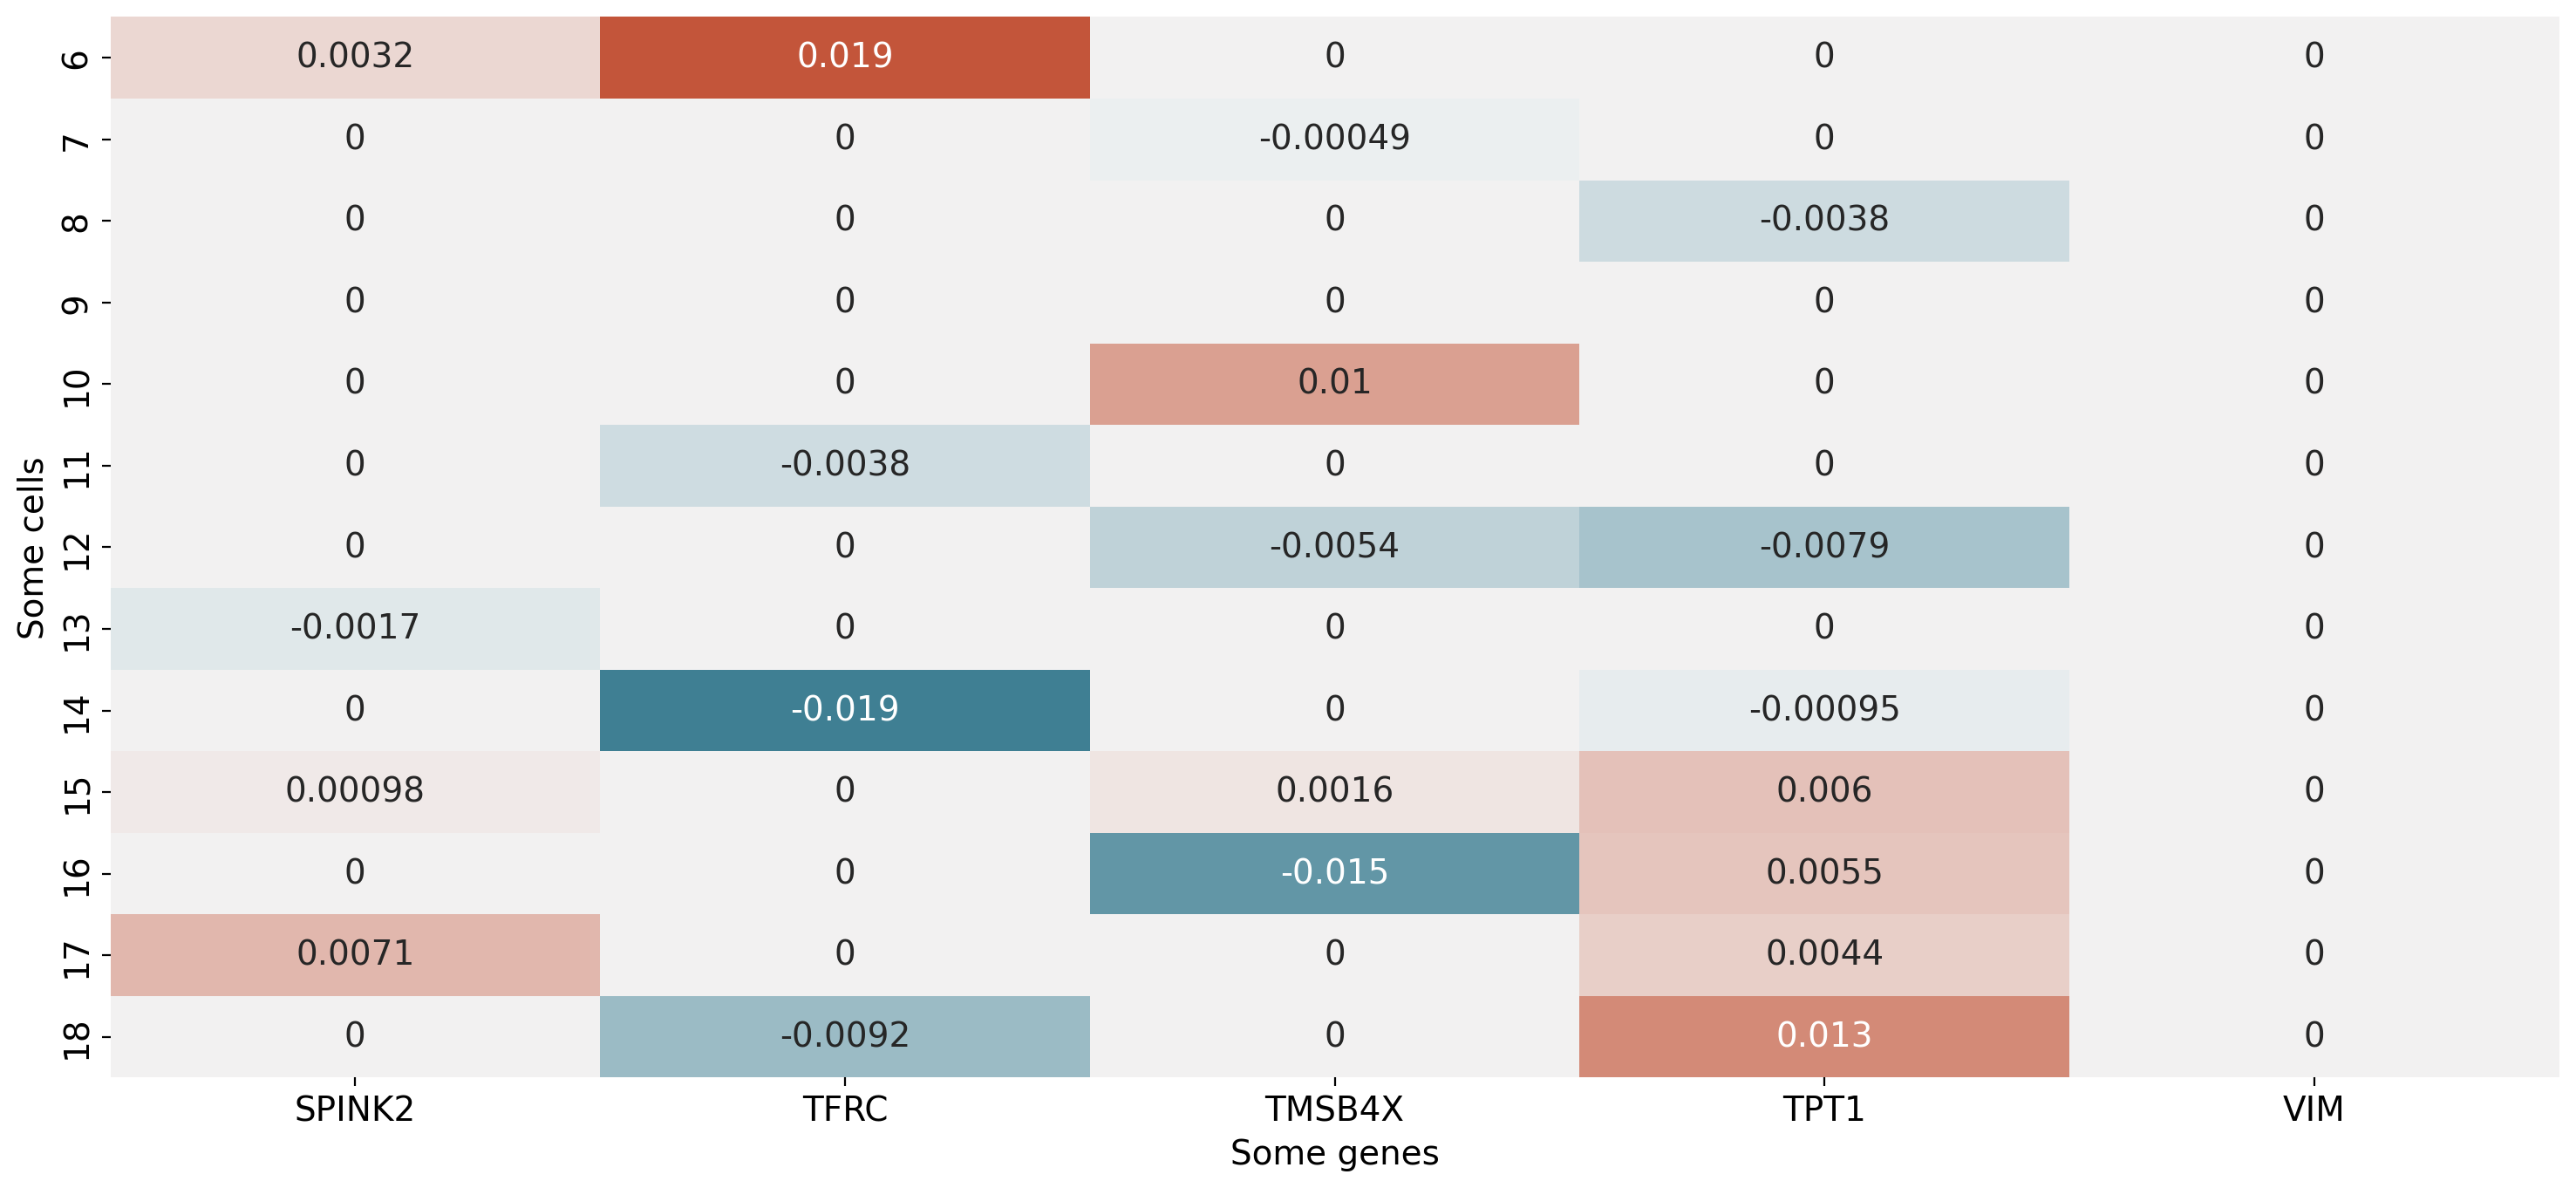

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
sns.heatmap(data_vis.iloc[6:19, -5:].astype(float), annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=False)

# Add title and labels
plt.xlabel('Some genes')
plt.xticks(rotation=0)
plt.ylabel('Some cells')
plt.grid(False)
plt.show()

#### efficiency
SHAP values add up to the difference between the expected model output and the actual output for a given input cell.

In [ ]:
# works for all proteins and all cells: difference is very small (e-07 -> approx)
protein_idx = 121
cell_idx = 0
shap_v = shap_values_16_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
shap_v

In [ ]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model16, test_dataloader).astype(np.float32)

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

In [ ]:
expected = explainer16_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - shap_v))
np.abs(expected - (predicted - shap_v)) <= 0.0001

In [ ]:
explainer16_p.expected_value.shape

#### consistency
higher feature value => non-decreasing shap value

In [27]:
# consistency:
X_test_plus_one = X_test_p_16.to_df().copy()
# X_test_plus_one['imp_83'] = X_test_plus_one['imp_83'] + 50   # +5 guarantees all values are above median
X_test_plus_one['imp_82'][0] = X_test_plus_one['imp_82'][0]+5
X_test_plus_one


,base_svd_0,base_svd_1,base_svd_2,base_svd_3,base_svd_4,base_svd_5,base_svd_6,base_svd_7,base_svd_8,base_svd_9,...,imp_74,imp_75,imp_76,imp_77,imp_78,imp_79,imp_80,imp_81,imp_82,imp_83
"CTCCCTCGTATGAAAC-1-('32606', 7)",73.963417,9.693662,9.681709,-5.698362,7.667257,-9.583122,5.160449,-3.405390,-5.452730,10.173450,...,0.000000,0.000000,0.000000,1.832402,0.000000,0.000000,2.066206,2.405848,7.444993,0.000000
"CATGCAATCGAAATCC-1-('27678', 7)",87.257217,-9.523611,25.474266,-13.235568,4.104650,-8.504361,1.242902,-1.349272,-6.141411,3.139475,...,0.000000,0.000000,0.000000,0.000000,1.620997,0.000000,1.952016,2.194078,2.202164,1.838837
"AAGCGAGGTTCATCGA-1-('31800', 7)",86.035782,-9.618085,24.647055,-10.741090,5.230818,-8.520335,0.938017,-1.645372,2.727859,-0.921169,...,1.715406,1.786931,0.000000,1.715406,0.000000,0.000000,1.974259,2.178230,2.223509,1.786931
"TTCGCTGAGAAAGTCT-1-('27678', 7)",87.303780,-8.365380,26.260628,-11.925523,3.919487,-10.763913,-0.246202,3.670309,-4.095333,1.141294,...,1.560909,1.757840,1.415746,1.757840,0.000000,0.000000,0.000000,2.179533,2.198908,1.637864
"TCCAGAACATCTCATT-1-('31800', 7)",79.363350,5.945584,14.293573,-9.740116,11.252848,-11.025636,3.665004,-6.680445,-2.635996,8.961347,...,0.000000,0.000000,0.000000,1.675226,0.000000,1.675226,2.056831,2.332885,2.336022,2.135140
"GGAGATGTCTGAGAAA-1-('32606', 7)",86.721558,-13.763405,23.489759,-8.599624,4.713495,-5.116483,2.232954,1.348689,-5.877008,3.289677,...,0.000000,0.000000,1.572647,0.000000,0.000000,0.000000,2.021909,2.233521,2.247757,1.788700
"CTTCCTTCACAAACGG-1-('27678', 7)",85.835426,-10.396303,30.863689,-10.947953,16.981718,-8.508432,7.045463,3.283935,3.095981,3.572914,...,0.000000,2.038031,1.838181,0.000000,0.000000,0.000000,1.971884,2.247967,2.221343,0.000000
"ACTATGGTCATGGTAC-1-('27678', 7)",85.306976,-13.261295,16.250536,-7.826189,11.390837,2.866236,-0.706950,-5.756642,-0.582483,4.862115,...,0.000000,0.000000,1.612047,0.000000,0.000000,0.000000,2.163874,2.089466,2.294323,0.000000
"GTGCACGCAACCTATG-1-('13176', 7)",87.146317,-5.844119,25.411106,-13.291170,13.864731,-10.017181,-2.817374,2.884317,-4.344737,-0.123033,...,1.281823,1.562067,1.784782,0.000000,1.430469,0.000000,1.924256,1.965786,2.051468,1.937446
"CCTCACACACAAGTGG-1-('27678', 7)",85.375710,-11.363231,24.140921,-15.379028,19.217768,-2.828063,-0.434139,-2.855862,1.084590,4.704502,...,0.000000,0.000000,1.837441,1.429248,0.000000,0.000000,2.072664,2.012387,2.154111,1.652437


In [28]:
# medians of last five handselected genes before and after +5
print(X_test_p_16.to_df().median().values.reshape((1,X_test_p_16.to_df().shape[1]))[:,-5:])
print(X_test_plus_one.median().values.reshape((1,X_test_plus_one.shape[1]))[:,-5:])


[[0.        1.8109733 2.214576  2.232008  1.9924533]]
[[0.         1.81097329 2.21457601 2.23200798 1.99245334]]


In [29]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16 = pd.DataFrame(test_loop(model16, test_dataloader).astype(np.float32))
pred16

  0%|          | 0/1 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-0.087728,-1.374420,-1.308007,0.424560,0.473042,1.953044,4.294698,-1.714505,-1.403456,-1.209518,...,-1.656819,0.986158,-1.310164,-1.588263,-0.343185,-1.440637,0.170067,0.411241,-0.290462,0.257146
1,-0.801930,-1.167034,-1.010183,1.301956,1.267419,1.555922,2.129416,-1.053784,-0.926659,-1.108356,...,-1.252820,2.041401,-0.889443,-1.304786,-1.099654,-1.052196,0.930301,-0.917012,0.292570,0.315518
2,-1.013711,-1.118660,-0.954443,1.367378,1.346959,1.126326,0.108117,-1.018309,-0.906498,-1.142691,...,-1.279094,2.098708,-0.756516,-1.296442,-1.130364,-1.031185,0.998396,-0.908143,0.857504,0.404144
3,-0.858080,-1.162020,-1.036942,1.201306,1.056731,1.603724,1.869174,-0.961254,-1.023658,-0.856388,...,-1.264413,1.709673,-1.083101,-1.254698,-1.083290,-1.094917,0.876540,-0.893148,-0.258286,0.353772
4,-0.147761,-1.373019,-1.342130,0.309756,0.575004,1.786025,5.151384,-1.557447,-1.329188,-1.241404,...,-1.616652,1.435069,-1.358119,-1.530344,-0.428739,-1.429953,0.293744,0.306281,-0.612080,0.108474
5,-1.293223,-1.258483,-1.076054,0.742574,0.834800,1.728452,2.051858,-0.947580,-1.045160,-1.042134,...,-1.382566,1.216868,-1.007035,-1.484354,-1.074397,-1.123378,0.655318,-1.103755,-0.083708,-0.030071
6,-1.158119,-1.088941,-1.220351,0.858473,0.784237,1.421710,-0.179457,-0.928541,-1.224572,-1.347762,...,-1.517528,1.194739,-1.235443,-1.463625,-1.274306,-1.326102,1.158458,-1.189323,-0.670088,0.230632
7,-0.932670,-1.155975,-1.095196,1.006951,0.602612,1.773565,1.006630,-1.081894,-1.031812,-1.346923,...,-1.373840,1.414291,-0.947171,-1.394521,-1.408749,-1.163088,1.760830,-1.092509,0.116530,0.432316
8,-0.925514,-1.147481,-1.075192,1.242133,1.058344,1.544124,2.372698,-1.041321,-0.993511,-1.154410,...,-1.332098,1.955110,-0.924228,-1.385019,-1.020103,-1.117395,0.730894,-0.856892,-0.210458,0.642178
9,-1.196968,-1.514406,-1.338975,0.252880,0.194671,2.346746,3.582901,-0.846641,-1.344889,-1.114596,...,-1.601792,0.842163,-1.318362,-1.634383,-1.551193,-1.393580,0.977191,-1.281966,-1.102414,0.041986


In [30]:
test_ds = CiteDataset_test(np.array(X_test_plus_one.astype(np.float32)))
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16plus = pd.DataFrame(test_loop(model16, test_dataloader).astype(np.float32))
pred16plus

  0%|          | 0/1 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-0.066336,-1.358775,-1.290031,0.407598,0.511634,1.907058,4.089550,-1.699926,-1.387388,-1.141765,...,-1.641920,0.979963,-1.299489,-1.570134,-0.406510,-1.416660,0.196231,0.354947,-0.277836,0.316387
1,-0.801930,-1.167034,-1.010183,1.301956,1.267419,1.555922,2.129416,-1.053784,-0.926659,-1.108356,...,-1.252820,2.041401,-0.889443,-1.304786,-1.099654,-1.052196,0.930301,-0.917012,0.292570,0.315518
2,-1.013711,-1.118660,-0.954443,1.367378,1.346959,1.126326,0.108117,-1.018309,-0.906498,-1.142691,...,-1.279094,2.098708,-0.756516,-1.296442,-1.130364,-1.031185,0.998396,-0.908143,0.857504,0.404144
3,-0.858080,-1.162020,-1.036942,1.201306,1.056731,1.603724,1.869174,-0.961254,-1.023658,-0.856388,...,-1.264413,1.709673,-1.083101,-1.254698,-1.083290,-1.094917,0.876540,-0.893148,-0.258286,0.353772
4,-0.147761,-1.373019,-1.342130,0.309756,0.575004,1.786025,5.151384,-1.557447,-1.329188,-1.241404,...,-1.616652,1.435069,-1.358119,-1.530344,-0.428739,-1.429953,0.293744,0.306281,-0.612080,0.108474
5,-1.293223,-1.258483,-1.076054,0.742574,0.834800,1.728452,2.051858,-0.947580,-1.045160,-1.042134,...,-1.382566,1.216868,-1.007035,-1.484354,-1.074397,-1.123378,0.655318,-1.103755,-0.083708,-0.030071
6,-1.158119,-1.088941,-1.220351,0.858473,0.784237,1.421710,-0.179457,-0.928541,-1.224572,-1.347762,...,-1.517528,1.194739,-1.235443,-1.463625,-1.274306,-1.326102,1.158458,-1.189323,-0.670088,0.230632
7,-0.932670,-1.155975,-1.095196,1.006951,0.602612,1.773565,1.006630,-1.081894,-1.031812,-1.346923,...,-1.373840,1.414291,-0.947171,-1.394521,-1.408749,-1.163088,1.760830,-1.092509,0.116530,0.432316
8,-0.925514,-1.147481,-1.075192,1.242133,1.058344,1.544124,2.372698,-1.041321,-0.993511,-1.154410,...,-1.332098,1.955110,-0.924228,-1.385019,-1.020103,-1.117395,0.730894,-0.856892,-0.210458,0.642178
9,-1.196968,-1.514406,-1.338975,0.252880,0.194671,2.346746,3.582901,-0.846641,-1.344889,-1.114596,...,-1.601792,0.842163,-1.318362,-1.634383,-1.551193,-1.393580,0.977191,-1.281966,-1.102414,0.041986


In [31]:
pred16plus.iloc[1:].equals(pred16.iloc[1:])

True

In [32]:
# check for which proteins the prediction with the new feature value is greater than with the old one
# new SHAP values for the proteins where this is true should be greater than the old ones
pred16plus.iloc[0] > pred16.iloc[0]

0       True
1       True
2       True
3      False
4       True
       ...  
135     True
136     True
137    False
138     True
139     True
Name: 0, Length: 140, dtype: bool

In [33]:
# shap_values_16_p_5_plus_one = explainer16_p.shap_values(X_test_plus_one.astype(np.float32), nsamples=300)
# np.save('shap_values_16_p_5_plus_one.npy', np.array(shap_values_16_p_5_plus_one, dtype=object), allow_pickle=True)
shap_values_16_p_5_plus_one = np.load('shap_values_16_p_5_plus_one.npy', allow_pickle=True)

In [34]:
protein_idx = 135
print(shap_values_16_p_5_plus_one[protein_idx][0][210])  # new shap value
print(shap_values_16_p_5[protein_idx][0][210])           # old shap value, should be smaller or equal

0.014876387529452719
0.0


In [35]:
pd.DataFrame(shap_values_16_p_5[protein_idx])[210][0] <= pd.DataFrame(shap_values_16_p_5_plus_one[protein_idx])[210][0]

True

In [36]:
for protein in range(0,140):
    if (pred16plus.iloc[0] > pred16.iloc[0])[protein]:
        # print(protein)
        # print(shap_values_16_p_5_plus_one[protein][0][210])  # new shap value
        # print(shap_values_16_p_5[protein][0][210])           # old shap value, should be smaller or equal
        # print(shap_values_16_p_5_plus_one[protein][0][210] >= shap_values_16_p_5[protein][0][210])
        if shap_values_16_p_5_plus_one[protein][0][210] < shap_values_16_p_5[protein][0][210]:
            print(protein)   # indices of proteins where consistency does not hold ... ?

7
23
40
88
102
139


### waterfall

In [ ]:
# explainer_w = shap.KernelExplainer(model16, med)
# shap_vals = explainer_w(X_test_p.to_df())


In [ ]:
# with open("explanation.pkl", "wb") as file:
#     pickle.dump(shap_vals, file)

In [ ]:
# np.save('shap_vals_waterfall_data.npy', np.array(shap_vals.data, dtype=object), allow_pickle=True)

In [ ]:
with open("explanation.pkl", "rb") as file:
    shap_vals_waterfall = pickle.load(file)

In [ ]:
shap_vals_waterfall

In [ ]:
shap.plots.waterfall(shap_vals_waterfall[0][0], max_display=14)

In [ ]:
shap.plots.waterfall(shap_values_16_p_5, max_display=14)

### steps for model 17: compute shap values on 50 samples per cell type

In [33]:
X_train_p_17 = pd.read_pickle('private_X_train_svd_64.pkl')
X_train_p_17 = X_train_p_17.iloc[np.sort(X_train_p_sampled.obs['ID'])]      # use 160 samples per cell type -> even distr.

X_test_p_17 = ad.read_h5ad('private_test_input_64_svd_5_samples.h5ad')

print('X_train: ', X_train_p_17.shape)
print('X_test: ', X_test_p_17.shape)

med = X_train_p_17.median().values.reshape((1,X_train_p_17.shape[1]))
explainer17_p = shap.KernelExplainer(model17, med)

# shap_values_17_p = explainer17_p.shap_values(X_test_p_17.to_df(), nsamples=300)

X_train:  (1120, 148)
X_test:  (35, 148)


In [38]:
# np.save('shap_values_17_50_samples_p_ct_distr.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)
# np.save('shap_values_17_p_5_properties.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)

In [34]:
shap_values_17_p_5 = np.load('shap_values_17_p_5_properties.npy', allow_pickle=True)

### check SHAP properties:

#### dummy

In [ ]:
# median of X_train (same median used for training explainer) of last column
X_test_p_dummy = X_test_p_17.to_df().copy()
last_column_median = med[:,-1]
# Replace the last column with the median value for all rows
X_test_p_dummy.iloc[:, -1] = last_column_median
# shap_values_17_p_5_dummy = explainer17_p.shap_values(X_test_p_dummy, nsamples=300)
# np.save('shap_values_17_p_5_properties_set_median_train.npy', np.array(shap_values_17_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_17_p_5_dummy = np.load('shap_values_17_p_5_properties_set_median_train.npy', allow_pickle=True)
pd.DataFrame(shap_values_17_p_5_dummy[127])

#### efficiency

In [ ]:
# works for all proteins and all cells: difference is very small (e-07 -> approx)
protein_idx = 121
cell_idx = 0
shap_v = shap_values_17_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
shap_v

In [ ]:
test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model17, test_dataloader).astype(np.float32)

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

In [ ]:
expected = explainer17_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - shap_v))
np.abs(expected - (predicted - shap_v)) <= 0.0001

### ensemble analysis

Combine handselected genes of model 16 and 17 only. \
Weighted sum of the respective shap values. \
Check if these summed ensemble shap values fulfil the shap properties.

In [35]:
weights = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]   # ensemble weights from codebase
weight_sum = np.array(weights).sum()
# models 16 and 17 both have weight 1 -> normalize by weight_sum for this small ensemble of only 16 and 17
weight_16 = 1/2     # 1/2 since only 2? not 1 / weight_sum
weight_17 = 1/2     # 1 / weight_sum

In [36]:
shap_values_16_p_handselected = shap_values_16_p_5[:,:,-84:]

In [37]:
shap_values_17_p_handselected = shap_values_17_p_5[:,:,-84:]

In [38]:
shap_values_ensemble_p_handselected = weight_16 * shap_values_16_p_handselected + weight_17 * shap_values_17_p_handselected

#### dummy

fulfilled since weight_16 * 0 + weight_17 * 0 = 0

In [ ]:
shap_values_ensemble_p_dummy = weight_16 * shap_values_16_p_5_dummy[:,:,-84:] + weight_17 * shap_values_17_p_5_dummy[:,:,-84:]
pd.DataFrame(shap_values_ensemble_p_dummy[0])

#### efficiency

In [ ]:
protein_idx = 121
cell_idx = 0
shap_v_16 = shap_values_16_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
print(shap_v_16)
shap_v_17 = shap_values_17_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
print(shap_v_17)

In [ ]:
shap_v_ensemble = 1/2*shap_v_16+1/2*shap_v_17
shap_v_ensemble

In [ ]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16 = test_loop(model16, test_dataloader).astype(np.float32)

test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred17 = test_loop(model17, test_dataloader).astype(np.float32)

pred = weight_16 * pred16 + weight_17 * pred17

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

In [ ]:
expected16 = explainer16_p.expected_value[protein_idx]   # first protein
print(expected16)
expected17 = explainer17_p.expected_value[protein_idx]   # first protein
print(expected17)
expected_ensemble = 1/2*expected16 + 1/2*expected17
expected_ensemble

In [ ]:
np.abs(expected_ensemble - (predicted - shap_v_ensemble)) <= 0.0001

#### consistency

In [39]:
# input example to check consistency
# if changed, need to recompute shap values ... :(
row = 0

In [40]:
# consistency:
X_test_plus_one_16 = X_test_p_16.to_df().copy()
X_test_plus_one_16['imp_82'][row] = X_test_plus_one_16['imp_82'][row]+5
X_test_plus_one_17 = X_test_p_17.to_df().copy()
X_test_plus_one_17['imp_82'][row] = X_test_plus_one_17['imp_82'][row]+5

In [41]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16 = test_loop(model16, test_dataloader).astype(np.float32)

test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred17 = test_loop(model17, test_dataloader).astype(np.float32)

pred = weight_16 * pred16 + weight_17 * pred17

predicted = pd.DataFrame(pred)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
test_ds = CiteDataset_test(np.array(X_test_plus_one_16.astype(np.float32)))
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16plus = test_loop(model16, test_dataloader).astype(np.float32)

test_ds = CiteDataset_test(np.array(X_test_plus_one_17.astype(np.float32)))
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred17plus = test_loop(model17, test_dataloader).astype(np.float32)

pred = weight_16 * pred16plus + weight_17 * pred17plus

predicted_plus_one = pd.DataFrame(pred)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
predicted_plus_one.iloc[1:].equals(predicted.iloc[1:])

True

In [44]:
predicted_plus_one.iloc[row] > predicted.iloc[row]

0       True
1       True
2       True
3      False
4       True
       ...  
135     True
136    False
137    False
138    False
139     True
Name: 0, Length: 140, dtype: bool

In [45]:
# shap_values_16_p_5_plus_one = explainer16_p.shap_values(X_test_plus_one.astype(np.float32), nsamples=300)
# np.save('shap_values_16_p_5_plus_one.npy', np.array(shap_values_16_p_5_plus_one, dtype=object), allow_pickle=True)
shap_values_16_p_5_plus_one = np.load('shap_values_16_p_5_plus_one.npy', allow_pickle=True)

In [46]:
# shap_values_17_p_5_plus_one = explainer17_p.shap_values(X_test_plus_one_17.astype(np.float32), nsamples=300)
# np.save('shap_values_17_p_5_plus_one.npy', np.array(shap_values_17_p_5_plus_one, dtype=object), allow_pickle=True)
shap_values_17_p_5_plus_one = np.load('shap_values_17_p_5_plus_one.npy', allow_pickle=True)

In [47]:
shap_values_ensemble_plus_one = weight_16 * shap_values_16_p_5_plus_one[:,:,-84:] + weight_17 * shap_values_17_p_5_plus_one[:,:,-84:]

In [48]:
protein_idx = 15
print(pd.DataFrame(shap_values_ensemble_plus_one[protein_idx])[82][row])         # new ensemble shap values
print(pd.DataFrame(shap_values_ensemble_p_handselected[protein_idx])[82][row])   # old ensemble shap values -> should be smaller or equal

-0.040573532454517114
0.010389225481393786


In [49]:
(predicted_plus_one.iloc[row] > predicted.iloc[row]).value_counts()
# when changing the input, for 102 proteins the prediction increases -> relevant proteins for Consistency check

True     102
False     38
Name: 0, dtype: int64

In [50]:
counter = 0
for protein in range(0,140):
    if (predicted_plus_one.iloc[row] > predicted.iloc[row])[protein]:
        # print(protein)
        # print(shap_values_16_p_5_plus_one[protein][0][210])  # new shap value
        # print(shap_values_16_p_5[protein][0][210])           # old shap value, should be smaller or equal
        # print(shap_values_16_p_5_plus_one[protein][0][210] >= shap_values_16_p_5[protein][0][210])
        if shap_values_ensemble_plus_one[protein][row][82] < shap_values_ensemble_p_handselected[protein][row][82]:
            print(protein)   # indices of proteins where consistency does not hold ... ?
            counter += 1
            
counter

13
15
30
50
62
93
96
103
124
125
139


11

Now: check the cases where consistency does not hold in the ensemble (protein indices in the above cell).\
Should at least hold if consistency holds for both models...

In [52]:
pd.DataFrame(pred16plus[row] > pred16[row])

,0
0,True
1,True
2,True
3,False
4,True
...,...
135,True
136,True
137,False
138,True


In [51]:
pd.DataFrame(pred17plus[row] > pred17[row])

,0
0,False
1,True
2,True
3,False
4,True
...,...
135,True
136,False
137,False
138,False


Check the protein indices where both models have an increased prediction.\
In these cases both models and the ensemble fulfill the requirements for Consistency, so the SHAP values should be non-decreasing.

In [53]:
both_pred_increased = pd.DataFrame((pred16plus[row] > pred16[row]) & (pred17plus[row] > pred17[row]))
both_pred_increased

,0
0,False
1,True
2,True
3,False
4,True
...,...
135,True
136,False
137,False
138,False


In [54]:
both_pred_increased.value_counts()

False    70
True     70
dtype: int64

In [59]:
for protein in range(0,140):
    if both_pred_increased.iloc[protein][0]:
        # print(protein)
        # print(shap_values_16_p_5_plus_one[protein][0][210])  # new shap value
        # print(shap_values_16_p_5[protein][0][210])           # old shap value, should be smaller or equal
        # print(shap_values_16_p_5_plus_one[protein][0][210] >= shap_values_16_p_5[protein][0][210])
        if shap_values_ensemble_plus_one[protein][row][82] < shap_values_ensemble_p_handselected[protein][row][82]:
            print(protein)   # indices of proteins where consistency does not hold ... ?

30
124


Summary:
- changed the same feature value (+5) in data for model 16 and for model 17 (row 0, column imp_82)
- ran the models with the new value to get pred16plus and pred17plus
- computed new shap values using changed data to get shap_values_16_p_5_plus_one and shap_values_17_p_5_plus_one
- both_pred_increased is True for the proteins where both models' predictions increased, else False
- -> 70 False, 70 True => it is common for models trained on the same data to react in opposite directions 
- in the end, out of the many indices where Consistency didn't hold for the ensemble, only 2 are left to check (30 and 124) since they should work

In [65]:
print(shap_values_ensemble_plus_one[30][row][82])
print(shap_values_ensemble_p_handselected[30][row][82])
print(shap_values_ensemble_plus_one[30][row][82] - shap_values_ensemble_p_handselected[30][row][82])

0.007043915593605288
0.00751497306279994
-0.0004710574691946523


In [64]:
print(shap_values_ensemble_plus_one[124][row][82])
print(shap_values_ensemble_p_handselected[124][row][82])
print(shap_values_ensemble_plus_one[124][row][82] - shap_values_ensemble_p_handselected[124][row][82])

0.0015966243492682164
0.0021809538680977875
-0.0005843295188295711


=> in both cases the difference is very small: around 0.0005
=> approximation error?

=> in general, Consistency holds if the conditions are also fulfilled for models 16 and 17

Now: edge case where conditions are fulfilled in the ensemble but there is a model where they are not fulfilled\
-> i.e. proteins where both_pred_increased is False

In [67]:
(both_pred_increased == False).sum()

0    70
dtype: int64

In [79]:
counter = 0
for protein in range(0,140):
    if ~both_pred_increased.iloc[protein][0] and (predicted_plus_one.iloc[row] > predicted.iloc[row])[protein]:
        # print(protein)
        # print(shap_values_16_p_5_plus_one[protein][0][210])  # new shap value
        # print(shap_values_16_p_5[protein][0][210])           # old shap value, should be smaller or equal
        # print(shap_values_16_p_5_plus_one[protein][0][210] >= shap_values_16_p_5[protein][0][210])
        if shap_values_ensemble_plus_one[protein][row][82] < shap_values_ensemble_p_handselected[protein][row][82]:
            print(protein)   # indices of proteins where consistency does not hold ... ?
            counter += 1

counter

13
15
50
62
93
96
103
125
139


9

These are the 11-2 proteins seen before, where Consistency does not hold.\
Now, the difference is also two magnitudes higher than before -> no computational error:

In [73]:
i = 13
print(shap_values_ensemble_plus_one[i][row][82], 'supposed to be higher')
print(shap_values_ensemble_p_handselected[i][row][82], 'supposed to be lower')
print(shap_values_ensemble_plus_one[i][row][82] - shap_values_ensemble_p_handselected[i][row][82])

-0.013634853140093335 supposed to be higher
0.0071887182100393784 supposed to be lower
-0.020823571350132714


The following are protein indices for which both predictions decrease. For these, Consistency does not need to hold. These indices are also not among the 9 proteins seen above.

In [75]:
both_pred_decreased = pd.DataFrame((pred16plus[row] < pred16[row]) & (pred17plus[row] < pred17[row]))
print(both_pred_decreased[both_pred_decreased[0] == True].index)
print(len(both_pred_decreased[both_pred_decreased[0] == True].index))

Int64Index([3, 6, 14, 24, 46, 48, 57, 58, 77, 95, 97, 100, 110, 112, 119, 131,
            137],
           dtype='int64')
17


=> 70-17 = 53 cases with opposing directions\
out of those, 9 don't fulfil Consistency

9 out of 140 = 6.4%\
9 out of 53 = 17%\
53 out of 140 = 37.9%